# Random Forest

---

Aditya Marathe

## Imports and version

In [92]:
%matplotlib inline

import sys

import numpy as np

import pandas as pd

import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

**Local**:

In [48]:
sys.path.insert(1, './../')

import ana
import plotting
import transforms

**Version**:

In [49]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'NumPy {skl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.4
NumPy 1.4.1.post1


## Configuration

In [50]:
config = {
    'Cuts': [
        'Detector Quality',
        'Data Quality',
        'Cosmic Rej.',
        'Veto'
    ],
    'Transforms': [
        transforms.tf_290124_positive_energies,
        transforms.tf_290124_valid_pid,
        transforms.tf_120224_first_prong
    ],
    'XDataCols': [
        # Loose pre-selection IDs
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.numuid',
        # REM and SCP IDs
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid',
        # Reco. variables --> stuff I want to check...
        # Notes: Ok, so these variables don't actually work very well, and have
        # a feature importance < 0.05! I.e. they are useless.
        # 'rec.energy.numu.hadtrkE',
        'rec.energy.numu.lstmmuon',
        # 'rec.energy.numu.recomuonE',
        # 'ana.trk.kalman.tracks.PtToPmu',
        # 'ana.trk.kalman.tracks.Pmu'


    ],
    'YDataCols': [
        'ana.cat.event_type'
    ]
}

## Loading dataset

In [51]:
ds = ana.Datasets()

Datasets | Found the following: MINI_DATA_DIR, DATA_V2_DIR, DATA_V3_DIR, REALLY_MINI_DIR, COPYMERGED_C6_DIR, COPYMERGED_C7_DIR, COPYMERGED_C8_DIR, COPYMERGED_C9_DIR, COPYMERGED_C10_DIR


In [52]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from CM HDF5 files...


NOvAData | Loaded table from CM HDF5 files (1 / 3).
NOvAData | Loaded table from CM HDF5 files (2 / 3).
NOvAData | Loaded table from CM HDF5 files (3 / 3).
NOvAData | Initialised.


In [53]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)
data.fill_categorical(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled track kinematics.
NOvAData | Filled categorical data.


## Data prep.

In [54]:
cuts = ana.Cuts.init_nova_cuts()

In [55]:
# Cuts
for cut in config['Cuts']:
    data.table = cuts.apply_cut(cut, data.table)

Cuts     | Applied 'Detector Quality' cut (480_160 -> 401_900 events).
Cuts     | Applied 'Data Quality' cut (401_900 -> 401_891 events).
Cuts     | Applied 'Cosmic Rej.' cut (401_891 -> 149_666 events).
Cuts     | Applied 'Veto' cut (149_666 -> 135_451 events).


In [56]:
# Transforms
for tf in config['Transforms']:
    data.table = tf(df=data.table)


In [57]:
interesting_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.lstmnu',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt',
    # 'ana.cut.flag.cvn_pid',
    # 'ana.cut.flag.containment',
]

print('Number of interesting vars = ', len(interesting_vars))

Number of interesting vars =  32


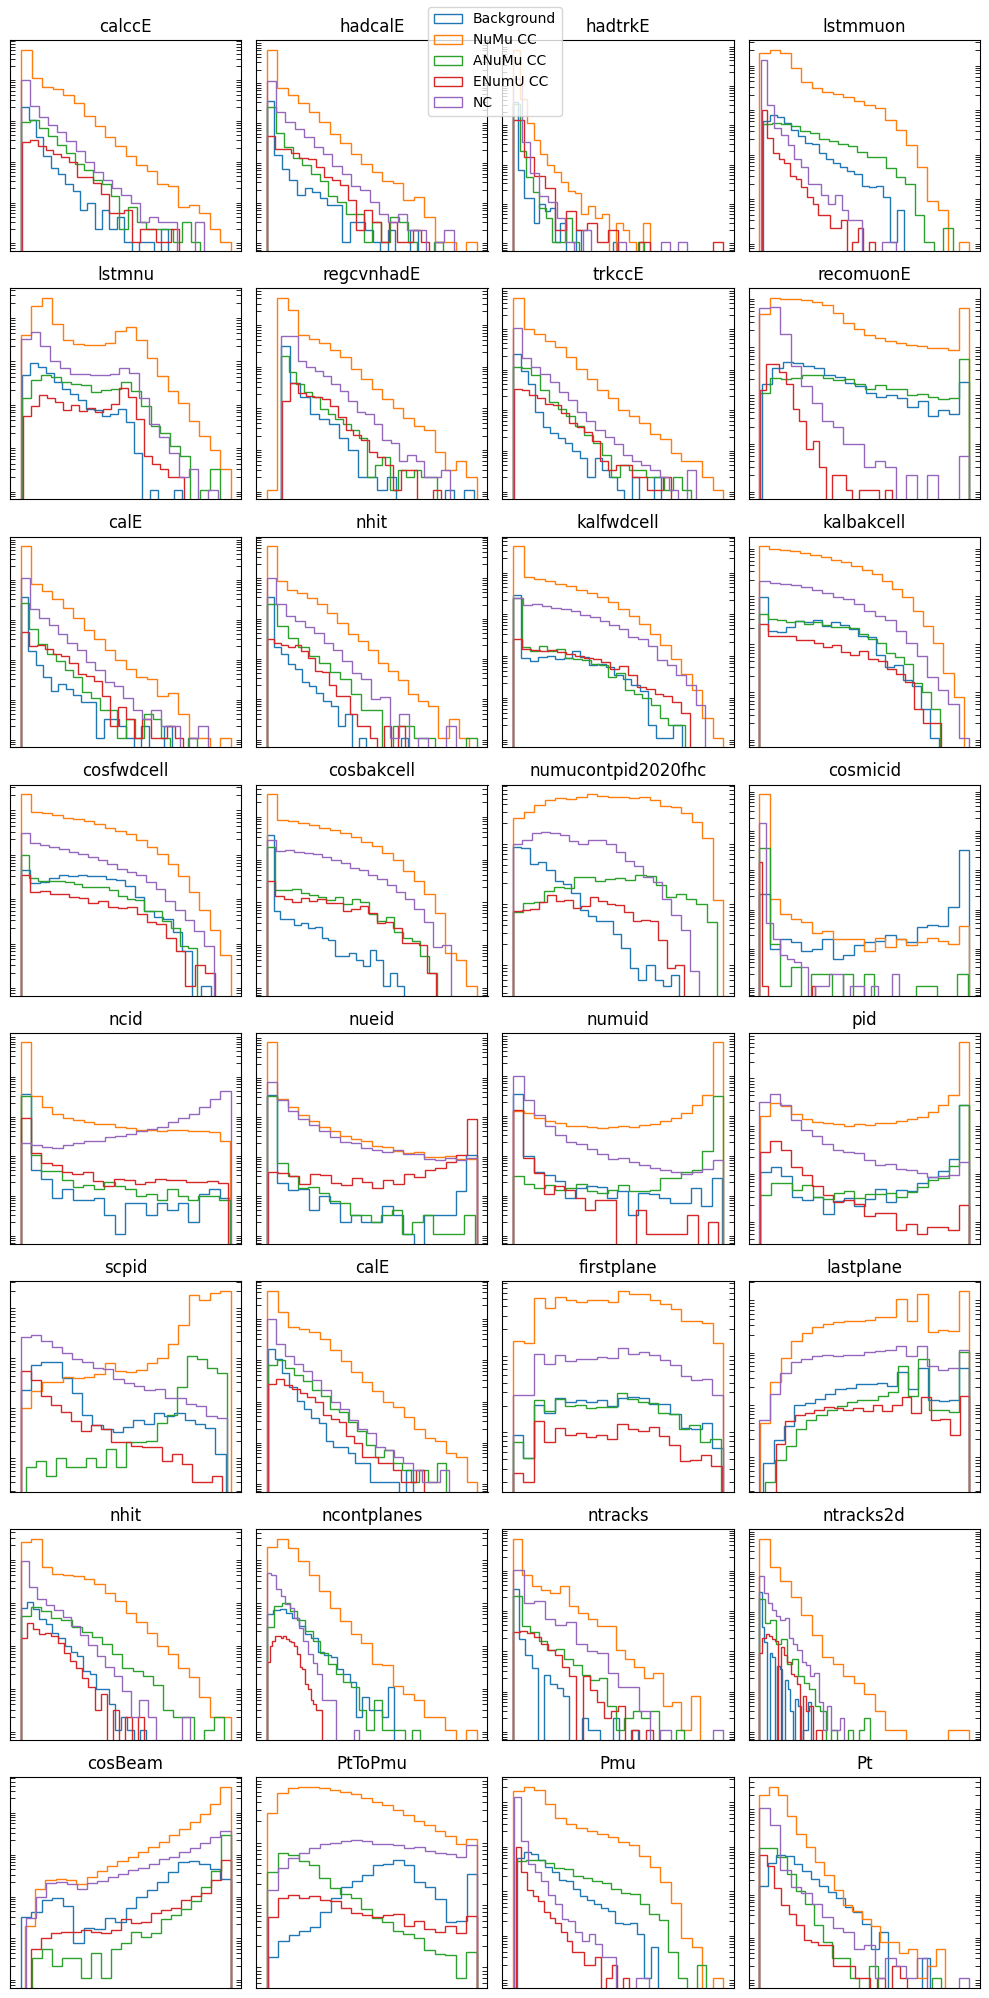

In [58]:
subplots = plotting.Subplots(8, 4, figsize=(10, 20))

for i, var in enumerate(interesting_vars):
    ax = subplots.axs[i]

    for id_, name in ana.EVENT_TYPE_MAP.items():
        *_, poly = ax.hist(
            data.table[data.table['ana.cat.event_type'] == id_][var],
            bins=20,
            label=name,
            histtype='step'
        )

    handles, labels = ax.get_legend_handles_labels()

    ax.set_yscale('log')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(var.split('.')[-1])

subplots.fig.legend(handles=handles, labels=labels, loc='upper center')

plt.tight_layout();

In [59]:
tt_split = data.train_test_split(
    x_cols=config['XDataCols'],
    y_cols=config['YDataCols'],
    test_size=0.3
)

tt_split['YTrain'] = tt_split['YTrain'].to_numpy().flatten()
tt_split['YTest'] = tt_split['YTest'].to_numpy().flatten()

In [60]:
ss = StandardScaler()
# x_table.loc[:, scale_vars] = ss.fit_transform(x_table[scale_vars])

## Random Forest

### API Reference

| Param. | Description |
| ------ | ----------- |
| `n_estimators` | The number of trees in the forest. |
| `criterion` | The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see Mathematical formulation. Note: This parameter is tree-specific. |
| `max_depth` | The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. |
| `min_samples_split` | The minimum number of samples required to split an internal node: If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split. | 
| `min_samples_leaf` | The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. If int, then consider min_samples_leaf as the minimum number. If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node. |
| `min_weight_fraction_leaf` | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. |
| `max_features` | The number of features to consider when looking for the best split: If int, then consider max_features features at each split. If float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at each split. If “sqrt”, then max_features=sqrt(n_features). If “log2”, then max_features=log2(n_features). If None, then max_features=n_features. |
| `max_leaf_nodes` | Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes. |
| `min_impurity_decrease` | A node will be split if this split induces a decrease of the impurity greater than or equal to this value. |
| `bootstrap` | Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. |
| `oob_score` | Whether to use out-of-bag samples to estimate the generalization score. By default, accuracy_score is used. Provide a callable with signature metric(y_true, y_pred) to use a custom metric. Only available if bootstrap=True. |
| `n_jobs` | The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details. |
| `random_state` | Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features). |
| `verbose` | Controls the verbosity when fitting and predicting.
| `warm_start` | When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. |
| `class_weight` | Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown. For multi-output, the weights of each column of y will be multiplied. Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.
| `ccp_alpha` | Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. |
| `max_samples` | If bootstrap is True, the number of samples to draw from X to train each base estimator. |

### Model Fitting

In [80]:
rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',  # None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100
    # 'oob_score': False,
}

In [81]:
rf = RandomForestClassifier(**rf_params)

In [82]:
# Encode event types 1 (NuMuCC), 2 (ANuMuCC) as signal.
y_train_encoded = ( (tt_split['YTrain'] == 1) + (tt_split['YTrain'] == 2) ) * 1.
y_test_encoded = ( (tt_split['YTest'] == 1) + (tt_split['YTest'] == 2) ) * 1.

In [83]:
rf.fit(
    X=tt_split['XTrain'],
    # y=tt_split['YTrain'],
    y=y_train_encoded,
    sample_weight=None
);

## Tuning

In [102]:
distributions = {
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 50, 100],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 100, 1_000],
    'min_impurity_decrease': [0.0, 0.3, 0.6, 1.0],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 400]
}

In [103]:
rf_test = RandomForestClassifier()

In [104]:
random_search = RandomizedSearchCV(
    estimator=rf_test,
    param_distributions=distributions,
    n_iter=10,
    scoring='precision',
    n_jobs=-1
)

In [105]:
rs_result = random_search.fit(
    X=tt_split['XTrain'],
    y=y_train_encoded
)

In [158]:
rf = rs_result.best_estimator_

In [159]:
import labbook

In [190]:
comments = f"""\
Classifier: Random Forest
-------------------------

Model parameters were fine-tuned using `RandomizedSearchCV`.

The best parameters were found to be:
{rs_result.best_params_}

I used the precision as the score, and got the best score of \
{rs_result.best_estimator_}.

Testing the classifier I found that cut-based analysis results in background \
contamination of about 0.3%, but this classifier has a background \
contamination of 3%!. That is 10x more!

However, there are 2.4x more signal events in the data. Also, rejecting the \
background events and reapplying all the cuts (inc. PID cut) except for the \
containment resulted in a 0.4% background contamination with a 2x increase in \
the signal count.

By reapplying the cuts, we can see the main issue with our classifier - it is \
falsely classifying NC and other background events as signal!
"""

labbook.add_log_skl(
    comments=comments,
    config_dict=config,
    model=rf,
    lb_dir='./../../labbook'
)

LabBook  | 26-02-2024 19:32 | Log saved!


### Re-fit

In [111]:
rf_best_params = rs_result.best_params_

In [112]:
rf = RandomForestClassifier(**rf_params)

In [113]:
# Encode event types 1 (NuMuCC), 2 (ANuMuCC) as signal.
y_train_encoded = ( (tt_split['YTrain'] == 1) + (tt_split['YTrain'] == 2) ) * 1.
y_test_encoded = ( (tt_split['YTest'] == 1) + (tt_split['YTest'] == 2) ) * 1.

In [114]:
rf.fit(
    X=tt_split['XTrain'],
    # y=tt_split['YTrain'],
    y=y_train_encoded,
    sample_weight=None
);

## Analysis

### Prediction

In [123]:
y_prediction = rf.predict(tt_split['XTest'])

In [124]:
# Encode event types 1 (NuMuCC), 2 (ANuMuCC) as signal.
# y_prediction_encoded = ( (y_prediction == 1) + (y_prediction == 2) ) * 1.
# y_test_encoded = ( (tt_split['YTest'] == 1) + (tt_split['YTest'] == 2) ) * 1.

In [125]:
func_kwargs = {'y_true': y_test_encoded, 'y_pred': y_prediction}

In [126]:
acc = accuracy_score(**func_kwargs)
pre = precision_score(**func_kwargs)
rec = recall_score(**func_kwargs)

print('Accuracy  :', acc)
print('Precision :', pre)
print('Recall    :', rec)

Accuracy  : 0.9316123188405797
Precision : 0.9907253066632474
Recall    : 0.9243529927822307


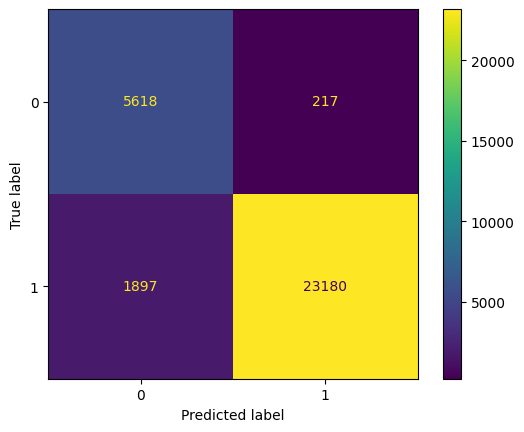

In [127]:
cm = confusion_matrix(**func_kwargs)
ConfusionMatrixDisplay(cm).plot();

In [140]:
c_data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from CM HDF5 files...
NOvAData | Loaded table from CM HDF5 files (1 / 3).
NOvAData | Loaded table from CM HDF5 files (2 / 3).
NOvAData | Loaded table from CM HDF5 files (3 / 3).
NOvAData | Initialised.


In [141]:
c_data.fill_ana_flags(inplace=True)
c_data.fill_categorical(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled categorical data.


In [142]:
table = cuts.apply_all_cuts(c_data.table)

Cuts     | Applied 'Detector Quality' cut (480_160 -> 401_900 events).
Cuts     | Applied 'Data Quality' cut (401_900 -> 401_891 events).
Cuts     | Applied 'CVN PID Score' cut (401_891 -> 91_605 events).
Cuts     | Applied 'Containment' cut (91_605 -> 42_160 events).
Cuts     | Applied 'Cosmic Rej.' cut (42_160 -> 41_327 events).
Cuts     | Applied 'Veto' cut (41_327 -> 41_239 events).


In [164]:
val_counts = table['ana.cat.event_type'].value_counts()
sig_count = val_counts[1] + val_counts[2]
bak_count = val_counts[0] + val_counts[3] + val_counts[4]

print(sig_count, bak_count)

41115 124


In [157]:
124 / (41115 + 124)

0.003006862436043551

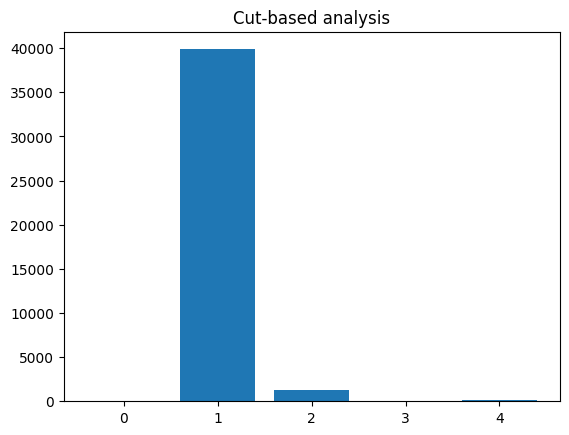

In [180]:
plt.bar(
    [0, 1, 2, 3, 4],
    [
        len(table[table['ana.cat.event_type'] == 0]),
        len(table[table['ana.cat.event_type'] == 1]),
        len(table[table['ana.cat.event_type'] == 2]),
        len(table[table['ana.cat.event_type'] == 3]),
        len(table[table['ana.cat.event_type'] == 4])
    ]
)
plt.title('Cut-based analysis');

In [152]:
y_prediction = rf.predict(c_data.table[config['XCols']])
y_prediction

array([1., 0., 0., ..., 0., 1., 0.])

In [154]:
y_true = c_data.table[config['YCols']].values.flatten()
y_true

array([1., 0., 0., ..., 0., 1., 0.])

In [155]:
print(
    'TP', len(y_prediction[(y_prediction == 1) & (y_true == 1)]), '\n'
    'TN', len(y_prediction[(y_prediction == 0) & (y_true == 0)]), '\n'
    'FP', len(y_prediction[(y_prediction == 1) & (y_true == 0)]), '\n'
    'FN', len(y_prediction[(y_prediction == 0) & (y_true == 1)])
)

TP 99632 
TN 322437 
FP 2662 
FN 14855


In [156]:
2662 / (99632 + 2662) 

0.02602303165386044

In [160]:
99632 / 41115

2.423251854554299

In [170]:
n_data = c_data.reset_index()
rf_cut_table = n_data.table[y_prediction == 1]
rf_cut_table = cuts.apply_all_cuts(
    rf_cut_table,
    except_=[
        'Containment'
    ]
)
val_counts = rf_cut_table['ana.cat.event_type'].value_counts()

sig_count = val_counts[1] + val_counts[2]
bak_count = val_counts[0] + val_counts[3] + val_counts[4]

print(sig_count, bak_count)

NOvAData | Initialised.
Cuts     | Applied 'Detector Quality' cut (108_311 -> 106_888 events).
Cuts     | Applied 'Data Quality' cut (106_888 -> 106_888 events).
Cuts     | Applied 'CVN PID Score' cut (106_888 -> 91_605 events).
Cuts     | Applied 'Cosmic Rej.' cut (91_605 -> 88_623 events).
Cuts     | Applied 'Veto' cut (88_623 -> 84_562 events).
84255 307


In [168]:
307 / (307 + 84255)

0.0036304723161703838

In [169]:
84255 / 41115

2.0492520977745348

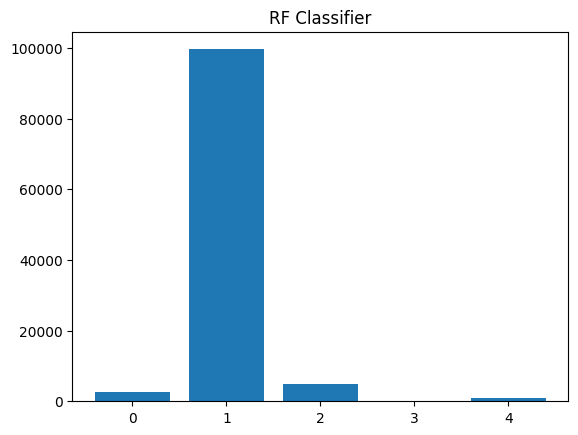

In [181]:
plt.bar(
    [0, 1, 2, 3, 4],
    [
        len(n_data.table[(y_prediction == 1) & (n_data.table['ana.cat.event_type'] == 0)]),
        len(n_data.table[(y_prediction == 1) & (n_data.table['ana.cat.event_type'] == 1)]),
        len(n_data.table[(y_prediction == 1) & (n_data.table['ana.cat.event_type'] == 2)]),
        len(n_data.table[(y_prediction == 1) & (n_data.table['ana.cat.event_type'] == 3)]),
        len(n_data.table[(y_prediction == 1) & (n_data.table['ana.cat.event_type'] == 4)])
    ]
)
plt.title('RF Classifier');

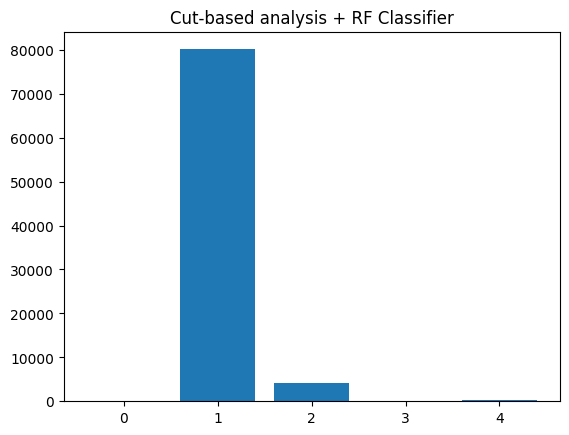

In [182]:
plt.bar(
    [0, 1, 2, 3, 4],
    [
        len(rf_cut_table[rf_cut_table['ana.cat.event_type'] == 0]),
        len(rf_cut_table[rf_cut_table['ana.cat.event_type'] == 1]),
        len(rf_cut_table[rf_cut_table['ana.cat.event_type'] == 2]),
        len(rf_cut_table[rf_cut_table['ana.cat.event_type'] == 3]),
        len(rf_cut_table[rf_cut_table['ana.cat.event_type'] == 4])
    ]
)
plt.title('Cut-based analysis + RF Classifier');

### Feature Importance

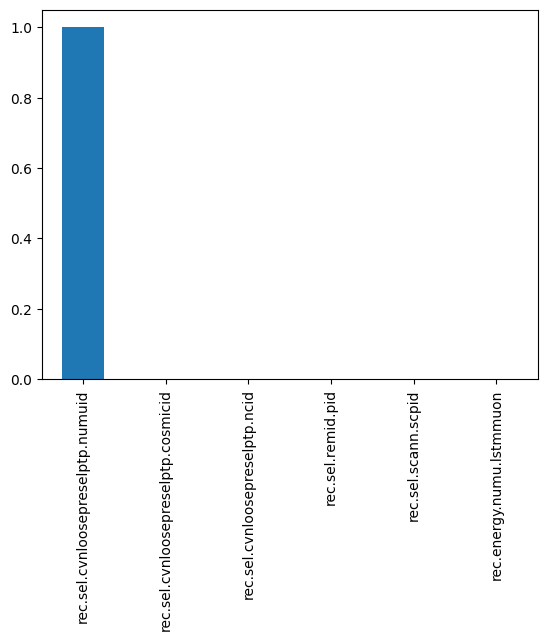

In [128]:
feature_importances = pd.Series(
    rf.feature_importances_,
    index=config['XCols']
).sort_values(ascending=False)
feature_importances.plot.bar();

### Plotting on feature space